# CVAE + GAN

### Определяем модели. 


In [1]:
import os
os.environ["KERAS_BACKEND"] = "torch"
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
# Импортируем необходимые библиотеки и модули
import keras
from keras.datasets import mnist
from keras.models import Model
from keras.layers import Input, Dense, Lambda, BatchNormalization, Dropout, Flatten, Reshape, Conv2D, LeakyReLU, Concatenate, MaxPool2D, UpSampling2D, RepeatVector
import torch
from torch.nn import MSELoss, BCELoss
from torchvision.utils import save_image
import numpy as np
import matplotlib.pyplot as plt

# Глобальные переменные
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size = 64
batch_shape = (batch_size, 28, 28, 1)
hidden_dim = 16
n_classes = 10
dropout_rate = 0.3
gamma = 1
lr = 0.0002

#Загрузка и предобработка данных
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
y_train_cat = keras.utils.to_categorical(y_train, n_classes).astype(np.float32)
x_test  = x_test.astype('float32') / 255.
y_test_cat = keras.utils.to_categorical(y_test, n_classes).astype(np.float32)

train_dataset = torch.utils.data.TensorDataset(
    torch.from_numpy(x_train.reshape(-1, 28, 28, 1)), torch.from_numpy(y_train_cat)
)
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, drop_last=True
)

test_dataset = torch.utils.data.TensorDataset(
    torch.from_numpy(x_test.reshape(-1, 28, 28, 1)), torch.from_numpy(y_test_cat)
)
test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=True, drop_last=True
)

def batchnorm_relu_dropout(x):
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    x = Dropout(dropout_rate)(x)
    return x

# Encoder
input_img = Input(shape=(28, 28, 1))
labels = Input(shape=(n_classes,))
x = Conv2D(32, kernel_size=(3, 3), strides=(2, 2), padding='same')(input_img)
x = batchnorm_relu_dropout(x)
x = MaxPool2D((2, 2), padding='same')(x)
x = Conv2D(64, kernel_size=(3, 3), padding='same')(x)
x = batchnorm_relu_dropout(x)
x = Flatten()(x)
x = Concatenate()([x, labels])

h = Dense(64)(x)
h = batchnorm_relu_dropout(h)

z_mean = Dense(hidden_dim)(h)
z_log_var = Dense(hidden_dim)(h)

def sampling(args):
    z_mean, z_log_vars = args
    N = torch.randn(size = (batch_size, hidden_dim)).to(device)
    return z_mean + torch.exp(torch.clip(z_log_vars/2, -2, 2)) * N

L = Lambda(sampling, output_shape=(hidden_dim,))([z_mean, z_log_var])

encoder = Model(inputs = [input_img , labels], outputs = [z_mean, z_log_var, L])

# Decoder
z = Input(shape=(hidden_dim,))
x = Concatenate()([z, labels])
x = Dense(7*7*128, activation='leaky_relu')(x)
x = batchnorm_relu_dropout(x)
x = Reshape((7, 7, 128))(x)
x = UpSampling2D(size=(2, 2))(x)

x = Conv2D(64, activation='leaky_relu' ,kernel_size=(5, 5), padding='same')(x)
x = batchnorm_relu_dropout(x)

x = Conv2D(32,activation='leaky_relu', kernel_size=(3, 3), padding='same')(x)
x = UpSampling2D(size=(2, 2))(x)
x = batchnorm_relu_dropout(x)

decoded = Conv2D(1, kernel_size=(5, 5), activation='sigmoid', padding='same')(x)
decoder = Model([z, labels], decoded)

def add_units_to_conv2d(conv2, units):
    dim1 = int(conv2.shape[1])
    dim2 = int(conv2.shape[2])
    dimc = int(units.shape[1])
    repeat_n = dim1*dim2
    units_repeat = RepeatVector(repeat_n)(labels)
    units_repeat = Reshape((dim1, dim2, dimc))(units_repeat)
    return Concatenate()([conv2, units_repeat])

# Discriminator
x = Conv2D(128, kernel_size=(7, 7), strides=(2, 2), padding='same')(input_img)
x = MaxPool2D((2, 2), padding='same')(x)
x = batchnorm_relu_dropout(x)
x = add_units_to_conv2d(x, labels)

x = Conv2D(64, kernel_size=(3, 3), padding='same')(x)
x = MaxPool2D((2, 2), padding='same')(x)
x = batchnorm_relu_dropout(x)

x = batchnorm_relu_dropout(x)

h = Flatten()(x)
d = Dense(1, activation='sigmoid')(h)

discriminator = Model([input_img, labels], [d])

_, _, encoded_img = encoder([input_img, labels])

# CVAE модель
cvae_model = Model([input_img, labels], decoder([encoded_img, labels]), name='cvae')

# Оптимизмторы
opt_enc = torch.optim.Adam(lr=lr, betas=(0.5, 0.999), params = encoder.parameters())
opt_dec = torch.optim.Adam(lr=lr, betas=(0.5, 0.999), params = decoder.parameters())
opt_dis = torch.optim.Adam(lr=lr, betas=(0.5, 0.999), params = discriminator.parameters())

# Потери
bce = BCELoss().to(device)
mse = MSELoss().to(device)

## Цикл обучения

In [ ]:
num_epochs = 20
x_fixed, y_fixed = test_dataset[:batch_size]

# Функция добавления шума на картинку
def add_salt_and_pepper_noise(x_fixed, p):
    mask = torch.rand(x_fixed.shape) > p
    x_noisy = x_fixed.clone()
    x_noisy[mask] = 0
    return x_noisy
# Добавляем шума на картинку. Потом будем сравнивать ее с восстановленной
x_noisy = add_salt_and_pepper_noise(x_fixed, 0.5)
save_image(x_noisy.permute(0, 3, 1, 2), 'results_2/init.png', nrow = 8)

criterion = BCELoss()
MSECriterion = MSELoss()

real_label = 1
fake_label = 0

loss_vae_h, loss_d_h, loss_g_h, = [], [], []

for epoch in range(num_epochs):
    for i, (x, y) in enumerate(train_dataloader, 0):
        x = x.to(device)
        y = y.to(device)
    
        label_real = torch.full((batch_size, 1), real_label, device=device).float()
        label_fake = torch.full((batch_size, 1), fake_label, device=device).float()

        ############################
        # Обновляем дискриминатор, обучаем его отличать real от fake
        # maximize log(D(x|y)) + log(1 - D(G(z|y)))
        ############################
        
        # Реальные 
        discriminator.zero_grad()
        output_real = discriminator([x, y])
        errD_real = criterion(output_real, label_real)
        errD_real.backward()
        D_x = output_real.mean().item()

        # Фейковые
        zp = torch.randn(batch_size, hidden_dim).to(device)
        fake_data = decoder([zp, y]).detach()  # detach to avoid backprop through G
        output_fake = discriminator([fake_data, y])
        errD_fake = criterion(output_fake, label_fake)
        errD_fake.backward()
        D_G_z1 = output_fake.mean().item()
        errD = errD_real + errD_fake
        opt_dis.step()

        ############################
        # Обновляем CVAE. Минимизируем функции потерь реконструкции и кросс-энтропии расстояния КЛ.
        ###########################
        encoder.zero_grad()
        decoder.zero_grad()
        
        z_mean, z_log_var, encoded_img = encoder([x, y])
        decoded_img = decoder([encoded_img, y])
        
        # Compute KLD and reconstruction loss
        KLD = -0.5 * torch.sum(1 + z_log_var - z_mean.pow(2) - z_log_var.exp())
        rec_loss = MSECriterion(decoded_img, x)
        VAE_loss = KLD + rec_loss
        VAE_loss.backward()
        opt_enc.step()
        opt_dec.step()

        ############################
        # Обновляем декодер
        # maximize log(D(G(z|y)))
        ############################
        decoder.zero_grad()
        z_mean, z_log_var, encoded_img = encoder([x, y])
        decoded_img = decoder([encoded_img, y])
        output = discriminator([decoded_img, y])
        errG = criterion(output, label_real)  # Обманываем дискриминатор
        errG.backward()
        D_G_z2 = output.mean().item()
        opt_dec.step()

        batches_done = epoch * len(train_dataloader) + i
        
        # Логирование
        if (batches_done % 50 == 0) or (batches_done == 3):
            print('[%d/%d][%d/%d] Loss_VAE: %.4f Loss_D: %.4f Loss_G: %.4f D(x|y): %.4f D(G(z|y)): %.4f / %.4f'
              % (epoch, num_epochs, i, len(train_dataloader),
                 VAE_loss.item(), errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
            loss_vae_h.append(VAE_loss.item())
            loss_d_h.append(errD.item())
            loss_g_h.append(errG.item())

        if batches_done % 100 == 0:
             with torch.no_grad():
                c = cvae_model([x_noisy, y_fixed])
             save_image(c.permute(0, 3, 1, 2), 'results_2/epoch%d_b%d.png' % (epoch, batches_done), nrow = 8)    

## Тестирование

### Было реализовано две модели, с разными гиперпараметрами
1) ### Модель без дропаута, и с разными скоростями обучения
2) ### Модель с дропаутом и одинаковыми скоростями обучения

## Лоссы в течение обучения

![image](Losses_nodrout,diff_lr.png)
![image](Losses_withdrout,same_lr.png)

Процесс восстановления изображения (модель с дропаутом)

![SegmentLocal](results_.gif "segment")
![image](init.png)

Восстанавливаем зашуленные цифры

In [4]:
cvae_model.load_weights("with_dp, same learn_rate.weights.h5")

Text(0.5, 1.0, 'Label 7')

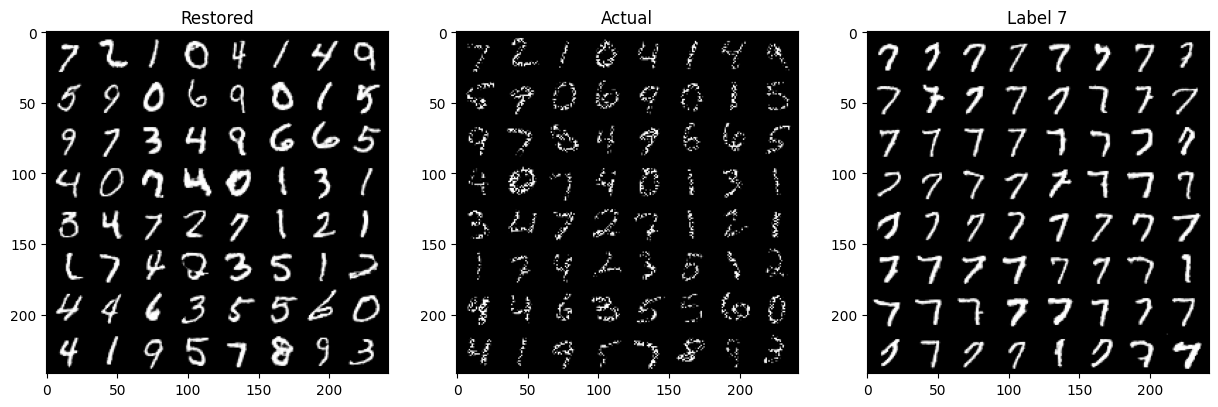

In [18]:
from torchvision.utils import make_grid

def add_salt_and_pepper_noise(x_fixed, p):
    mask = torch.rand(x_fixed.shape) > p
    x_noisy = x_fixed.clone()
    x_noisy[mask] = 0
    return x_noisy

x_test, y_test = test_dataset[:64]
x_test = add_salt_and_pepper_noise(x_test, 0.5)
labels = torch.zeros_like(y_test)
labels[:, 7] = 1

with torch.no_grad():
    c = cvae_model([x_test, y_test])
    b = cvae_model([x_test, labels])

restored = make_grid(c.permute(0, 3, 1, 2), nrow = 8, normalize=True)
actual = make_grid(x_test.permute(0, 3, 1, 2), nrow = 8, normalize=True)
diff_label = make_grid(b.permute(0, 3, 1, 2), nrow = 8, normalize=True)

fig, ax = plt.subplots(1, 3, figsize=(15,15))
ax[0].imshow(restored.permute(1,2,0).cpu())
ax[0].set_title('Restored')
ax[1].imshow(actual.permute(1,2,0).cpu())
ax[1].set_title('Actual')
ax[2].imshow(diff_label.permute(1,2,0).cpu())
ax[2].set_title('Label 7')